# Discovering Foodborne Illness in Online Restaurant Reviews - Offical Experiments File

This notebook walks through all experiments presented in the manuscript "Discovering Foodborne Illness in Online Restaurant Reviews." Since there are many files for the original experiments and they are very hard to follow, this notebook consolidates all results and experiments presented in the manuscript in one linearly runnable notebook.

For questions about this notebook, please contact Tom Effland at teffland@.cs.columbia.edu

Notes:
* This notebook does not include hyperparam tuning experiments, only the best found setting of parameters.  Those exploratory experiments can be found in `unofficial/Notebooks`. (Note they are _very_ difficult to follow)

In [225]:
# modules
import csv

# libraries
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn import preprocessing, metrics, cross_validation, grid_search
from sklearn.externals import joblib

# model components
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# plots
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

# Data Preprocessing

`all_data_from_dohmh.xlsx` contains the original annotations from the DOHMH epidemiologists
* This file contains multiple sheets with mixed schemas, with many missing labels or scores (basically it was unusable)
* To remedy this, Anna pulled out (by hand) the first (chronological) 1,392 (1/3) of the about 5,000 reviews that had good scores and annotations. These were put into `yelp_sick_data.csv` and `yelp_mult_data.csv`.
* These two files contain (almost) the same reviews, but with different labels for the Sick and Multiple tasks, respectively. 
* To train and test the models, we perform a stratified (by label) sampling of the reviews into 80% train, 20% test 

These data have the following issues, which we remedy below:

* There each have 1 review that doesn't appear in the other file
    * We remove both of these reviews. Data size 1392 -> 1391
* There are a few duplicates for some inexplicable reason
    * We remove all duplicates. Data size 1391 -> 1384
* The train/test splits are not stratified by restaurant and so there is a potential restaurant label bias
    * We remove all reviews from the test data that have a restaurant with at least one other review in the training data which shares the same label, for each task. This way no restaurant-specific features can be discriminative of class labels in the test set. Since the restaurant names were not saved during Anna's transfer, we look them up in the original csv. Data size: Sick: 1384 -> 1337, Multiple: 1384 -> 1333
    

### Load in the sick and multiple data, removing the reviews that are different or are duplicate

In [99]:
sick_df = pd.read_csv('yelp_sick_data.csv')
mult_df = pd.read_csv('yelp_mult_data.csv')
print len(sick_df), len(mult_df)

1392 1392


In [97]:
sick_review_set = set(sick_df['data'].tolist())
mult_review_set = set(mult_df['data'].tolist())
mismatch_review_set = sick_review_set ^ mult_review_set
# print len(mismatch_review_set)
# print mismatch_review_set
all_data = {}
for _, row in sick_df.iterrows():
    if row['data'] not in mismatch_review_set:
        all_data[row['data']] = {'sick_label':row['label'],
                                   'old_sick_score':row['old_score']}
    else:
        pass #print row
for _, row in mult_df.iterrows():
    if row['data'] not in mismatch_review_set:
        all_data[row['data']].update({'mult_label':row['label'],
                                      'old_mult_score':row['old_score']})
    else:
        pass #print row
    
print 'Resulting number of reviews after mismatches and duplicates removed: {}'.format(len(all_data))

Resulting number of reviews after mismatches and duplicates removed: 1384


In [131]:
sick_data = {'x':np.array(all_data.keys()), 
             'y':np.array([d['sick_label'] for d in all_data.values()]),
             'old_sick_score':np.array([d['old_sick_score'] for d in all_data.values()])}
mult_data = {'x':np.array(all_data.keys()), 
             'y':np.array([d['mult_label'] for d in all_data.values()]),
             'old_mult_score':np.array([d['old_mult_score'] for d in all_data.values()])}

### Now split into train and test sets, removing all data from the test sets that could be restaurant-biased. These are reviews that have a parent restaurant which has another review in the train data with the same label

In [132]:
# compile mapping of all reviews to restaurants
xls = pd.ExcelFile('all_data_from_dohmh.xlsx')
df1 = xls.parse('allreviews')
df2 = xls.parse('July 12-Mar 13')
df3 = xls.parse('May 2013-present')
all_reviews = df1['Review'].tolist() + df2['Review'].tolist() + df3['Review'].tolist()

review2restaurant = {r:b for r,b in zip(df1['Review'].tolist(), df1['Business'].tolist())}
review2restaurant.update({r:b for r,b in zip(df2['Review'].tolist(), df2['Business'].tolist())})
review2restaurant.update({r:b for r,b in zip(df3['Review'].tolist(), df3['Business'].tolist())})

In [178]:
# split up the data into train and test using class-stratified sampling
def split_dev_test(data, test_size=.2):
    """ Get a stratified random sample of reviews, dropping any biased teset reviews """
    restaurant_labelsets = {v: set([]) for v in review2restaurant.values()+['UNKNOWN']}
    for train, test in cross_validation.StratifiedShuffleSplit(data['y'], n_iter=1, test_size=test_size, random_state=0):
        train_data = {k:v[train] for k,v in data.items()}
        # get the restaurant of each review and add this review's label to its training label set
        for i in train:
            if data['x'][i] in review2restaurant:
                restaurant_labelsets[review2restaurant[data['x'][i]]] |= set([data['y'][i]])
            else: 
                # a few are missing the restaurant
                # this is likely an encoding error
                # but we take a conservative approach
                # by calling these all 'UNKNOWN' 
                # which causes all unknowns in test to be dropped
                restaurant_labelsets['UNKNOWN'] |= set([data['y'][i]])
                
        # for each test document
        # make sure that its restaurant does not have a review with the same label in the training set
        # if it does, then omit it from the test data
        good_idxs = []
        for i in test:
            review_restaurant = review2restaurant[data['x'][i]] if data['x'][i] in review2restaurant else 'UNKNOWN'
            if data['y'][i] not in restaurant_labelsets[review_restaurant]:
                good_idxs.append(i)
        good_idxs = np.array(good_idxs)
        test_data = {k:v[good_idxs] for k,v in data.items()}
        
        
    print "Training/Dev data shape: ", train_data['x'].shape, train_data['y'].shape
    print "Test data shape: ",test_data['x'].shape, test_data['y'].shape
    return train_data, test_data

print "Sick data:"
sick_train, sick_test = split_dev_test(sick_data)
print "Mult data:"
mult_train, mult_test = split_dev_test(mult_data)

Sick data:
Training/Dev data shape:  (1107,) (1107,)
Test data shape:  (230,) (230,)
Mult data:
Training/Dev data shape:  (1107,) (1107,)
Test data shape:  (226,) (226,)


# Experiments for old classifier AUCs

In [179]:
def bootstrap_auc_ci(preds, trues, alpha=.05, B=1000, random_seed=0):
    """ Bootstrap a 1-alpha CI around AUC scores for a classifiers predictions. """
    npr.seed(random_seed)
    N = len(preds)
    sample_indices = (npr.choice(range(N), size=N, replace=True) for b in range(B))
    # run simulation
    bootstrap = []
    for i, idx in enumerate(sample_indices):
        if i % (B/100) == 0: print '\r',100*(i)/(float(B)), '%',
        auc = metrics.roc_auc_score(trues[idx], preds[idx], average='micro')
        bootstrap.append(auc)
    print
    # calculate ci
    bootstrap.sort()
    low_idx = int(np.ceil(B*(alpha/2.)))
    high_idx = int(np.floor(B*(1.-alpha/2.)))
#     print low_idx, high_idx
    ci = (bootstrap[low_idx], bootstrap[high_idx])
    return bootstrap, ci

### The AUC of the old sick classifier, on the test split of the data

In [158]:
old_auc = metrics.roc_auc_score(sick_test['y'], sick_test['old_sick_score'], average='micro')
_, old_ci = bootstrap_auc_ci(sick_test['old_sick_score'], sick_test['y'], B=10000)
print 'OLD SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(old_auc, old_ci[0], old_ci[1])

99.0 %
OLD SICK AUC: 0.67, 95% CI: (0.62, 0.73)


### The AUC of the old multiple classifier, on the test split of the data

In [159]:
old_auc = metrics.roc_auc_score(mult_test['y'], mult_test['old_mult_score'], average='micro')
_, old_ci = bootstrap_auc_ci(mult_test['old_mult_score'], mult_test['y'], B=10000)
print 'OLD MULT AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(old_auc, old_ci[0], old_ci[1])

99.0 %
OLD MULT AUC: 0.66, 95% CI: (0.57, 0.75)


# Experiments for new classifier AUCs

## Sick Experiments

### SVM

In [162]:
# best svm for sick
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 3), 
        analyzer=u'word', 
        max_df=.93, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        )
tfidf = TfidfTransformer(norm='l2', use_idf=True)
svc = SVC(kernel='linear', C=30, probability=True)
sick_svm = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('svc',svc)
    ])

# fit model and get results
sick_svm.fit(sick_train['x'], sick_train['y'])
sick_svm_scores = sick_svm.predict_proba(sick_test['x'])[:,1]
sick_svm_auc = metrics.roc_auc_score(sick_test['y'], sick_svm_scores, average='micro')
_, sick_svm_ci = bootstrap_auc_ci(sick_svm_scores, sick_test['y'], B=10000)
print 'BEST SVM SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(sick_svm_auc, sick_svm_ci[0], sick_svm_ci[1])

99.0 %
BEST SVM SICK AUC: 0.88, 95% CI: (0.83, 0.92)


### Random Forest

In [187]:
# best random forest for sick
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 2), 
        analyzer=u'word', 
        max_df=.94, 
        min_df=1, 
        max_features=1000, 
        vocabulary=None, 
        binary=False, 
        )
tfidf = TfidfTransformer(norm='l1', use_idf=True)
rf = RandomForestClassifier(
    oob_score=True,
    n_estimators=150,
    max_depth=None,
    max_features='sqrt',
    random_state=0
)
sick_rf = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('rf',rf)
    ])

# fit model and get results
sick_rf.fit(sick_train['x'], sick_train['y'])
sick_rf_scores = sick_rf.predict_proba(sick_test['x'])[:,1]
sick_rf_auc = metrics.roc_auc_score(sick_test['y'], sick_rf_scores, average='micro')
_, sick_rf_ci = bootstrap_auc_ci(sick_rf_scores, sick_test['y'], B=10000)
print 'BEST RANDOM FOREST SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(sick_rf_auc, sick_rf_ci[0], sick_rf_ci[1])

99.0 %
BEST RANDOM FOREST SICK AUC: 0.86, 95% CI: (0.81, 0.90)


### Logistic Regression

In [213]:
# best logistic regression for sick
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 3), 
        analyzer=u'word', 
        max_df=.95, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        )
tfidf = TfidfTransformer(norm='l2', use_idf=True)
logreg = LogisticRegression(
    fit_intercept=True, 
    C=100, 
    penalty='l2'
)
sick_logreg = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('logreg',logreg)
    ])

# fit model and get results
sick_logreg.fit(sick_train['x'], sick_train['y'])
sick_logreg_scores = sick_logreg.predict_proba(sick_test['x'])[:,1]
sick_logreg_auc = metrics.roc_auc_score(sick_test['y'], sick_logreg_scores, average='micro')
_, sick_logreg_ci = bootstrap_auc_ci(sick_logreg_scores, sick_test['y'], B=10000)
print 'BEST LOGISTIC REGRESSION SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    sick_logreg_auc, sick_logreg_ci[0], sick_logreg_ci[1])

best_params = sick_logreg.get_params()

99.0 %
BEST LOGISTIC REGRESSION SICK AUC: 0.88, 95% CI: (0.83, 0.92)


## Multiple Experiments

### SVM

In [188]:
# best svm for mult
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 3), 
        analyzer=u'word', 
        max_df=.91, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        )
tfidf = TfidfTransformer(norm='l2', use_idf=True)
svc = SVC(kernel='linear', C=.1, probability=True)
mult_svm = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('svc',svc)
    ])

# fit model and get results
mult_svm.fit(mult_train['x'], mult_train['y'])
mult_svm_scores = mult_svm.predict_proba(mult_test['x'])[:,1]
mult_svm_auc = metrics.roc_auc_score(mult_test['y'], mult_svm_scores, average='micro')
_, mult_svm_ci = bootstrap_auc_ci(mult_svm_scores, mult_test['y'], B=10000)
print 'BEST SVM MULT AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(mult_svm_auc, mult_svm_ci[0], mult_svm_ci[1])

99.0 %
BEST SVM MULT AUC: 0.89, 95% CI: (0.82, 0.95)


### Random Forest

In [202]:
# best random forest for mult
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 3), 
        analyzer=u'word', 
        max_df=.92, 
        min_df=1, 
        max_features=1000, 
        vocabulary=None, 
        binary=False, 
        )
tfidf = TfidfTransformer(norm='l2', use_idf=True)
rf = RandomForestClassifier(
    oob_score=True,
    n_estimators=200,
    max_depth=50,
    max_features='sqrt',
    random_state=0
)
mult_rf = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('rf',rf)
    ])

# fit model and get results
mult_rf.fit(mult_train['x'], mult_train['y'])
mult_rf_scores = mult_rf.predict_proba(mult_test['x'])[:,1]
mult_rf_auc = metrics.roc_auc_score(mult_test['y'], mult_rf_scores, average='micro')
_, mult_rf_ci = bootstrap_auc_ci(mult_rf_scores, mult_test['y'], B=10000)
print 'BEST RANDOM FOREST MULT AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    mult_rf_auc, mult_rf_ci[0], mult_rf_ci[1])

99.0 %
BEST RANDOM FOREST MULT AUC: 0.83, 95% CI: (0.76, 0.90)


### Logistic Regression

In [204]:
# best logistic regression for mult
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 3), 
        analyzer=u'word', 
        max_df=.92, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        )
tfidf = TfidfTransformer(norm='l2', use_idf=True)
logreg = LogisticRegression(
    fit_intercept=True, 
    C=190, 
    penalty='l2'
)
mult_logreg = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('logreg',logreg)
    ])

# fit model and get results
mult_logreg.fit(mult_train['x'], mult_train['y'])
mult_logreg_scores = mult_logreg.predict_proba(mult_test['x'])[:,1]
mult_logreg_auc = metrics.roc_auc_score(mult_test['y'], mult_logreg_scores, average='micro')
_, mult_logreg_ci = bootstrap_auc_ci(mult_logreg_scores, mult_test['y'], B=10000)
print 'BEST LOGISTIC REGRESSION MULT AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    mult_logreg_auc, mult_logreg_ci[0], mult_logreg_ci[1])

99.0 %
BEST LOGISTIC REGRESSION MULT AUC: 0.90, 95% CI: (0.83, 0.95)


# Precision and Recall for Best Logistic Regressions, used for error analysis

First we compute the best thresholds from the ROC cureves using Youden's J statistic (this is particularly important for the multiple classifier)

Then we report the confusion matrices.

The actual error analysis was done on Anna's laptop and unfortunately cannot be reproduced for publication.

In [ ]:
def youdens_J(fpr, tpr, thresholds):
    """Computes the best decision threshold along a ROC curve according to Youden's J statistic
    
    The J statistic is equivalent to the point of maximum distance from the ROC curve to the diaganol line.
    This point marks the maximum point of informedness over random guessing. 
    It is equivalently the likelihood of a positive classification of a positive sample versus a negative sample.
    
    Args:
        fpr(array(float)): array of false positive rates
        tpr(array(float)): array of true postiive rates
        thresholds(array(float)): array of thresholds the fpr and tpr were calculated from
        
    Returns:
        (best_j,best_fpr,best_tpr,best_threshold)(float,float,float,float): 4-tuple of the best J statistic 
            and the accompanying values of fpr, tpr and decision threshold that generated that J
            
    References:
        https://en.wikipedia.org/wiki/Youden%27s_J_statistic
        
        Schisterman, E.F.; Perkins, N.J.; Liu, A.; Bondell, H. (2005). 
        "Optimal cut-point and its corresponding Youden Index to discriminate individuals using pooled blood samples". 
        Epidemiology 16: 73–81. doi:10.1097/01.ede.0000147512.81966.ba
    """
    max_J = -1
    best_index = 0
    for i in range(len(fpr)):
        if ((1 - fpr[i]) + tpr[i] - 1 > max_J):
            max_J = (1 - fpr[i]) + tpr[i] - 1
            best_index = i
    return (max_J, fpr[best_index], tpr[best_index], thresholds[best_index])

In [279]:
def plot_confusion_matrix(cm, label_names, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    
    min_val, max_val, diff = 0., len(cm.astype('float')[:,0]), 1.

    #text portion
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = "%i = %0.2f" % (cm.astype('int')[x_val, y_val], cm_normalized[x_val, y_val])
        color = 'w' if cm[x_val, y_val] > .5*np.max(cm) else 'k'
        ax.text(y_val, x_val, c, color=color, va='center', ha='center')

    #set tick marks for grid
    ax.set_xticks(np.arange(min_val-diff/2, max_val-diff/2))
    ax.set_yticks(np.arange(min_val-diff/2, max_val-diff/2))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(min_val-diff/2, max_val-diff/2)
    ax.set_ylim(min_val-diff/2, max_val-diff/2)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names)#, rotation=45)
    plt.yticks(tick_marks, label_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Youden's sick threshold: 0.49


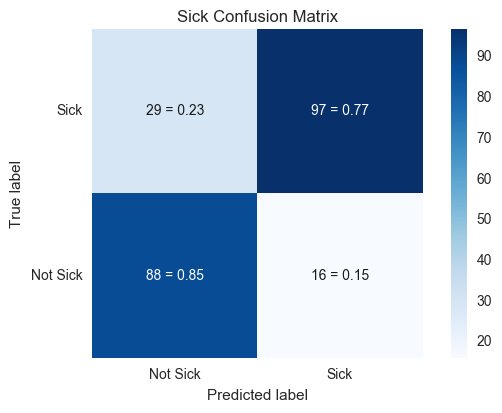

In [280]:
sick_scores = sick_logreg.predict_proba(sick_test['x'])[:,1]
_, _, _, sick_threshold = youdens_J(*metrics.roc_curve(sick_test['y'], sick_scores))
print 'Youden\'s sick threshold: {0:2.2f}'.format(sick_threshold)
sick_preds = (sick_scores >= sick_threshold).astype(np.int32)
sick_cm = metrics.confusion_matrix(y_true=sick_test['y'], y_pred=sick_preds)
plot_confusion_matrix(sick_cm, ['Not Sick', 'Sick'], 'Sick Confusion Matrix')

Youden's multiple threshold: 0.04


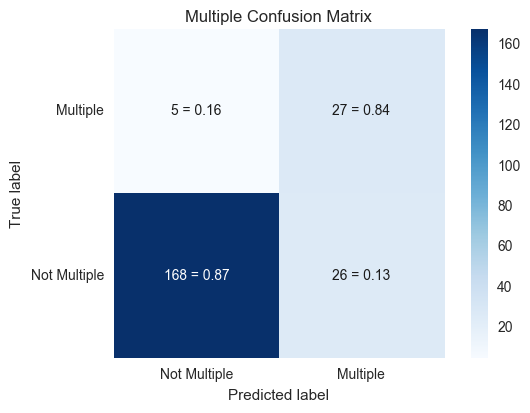

In [282]:
mult_scores = mult_logreg.predict_proba(mult_test['x'])[:,1]
_, _, _, mult_threshold = youdens_J(*metrics.roc_curve(mult_test['y'], mult_scores))
print 'Youden\'s multiple threshold: {0:2.2f}'.format(mult_threshold)
mult_preds = (mult_scores >= mult_threshold).astype(np.int32)
mult_cm = metrics.confusion_matrix(y_true=mult_test['y'], y_pred=mult_preds)
plot_confusion_matrix(mult_cm, ['Not Multiple', 'Multiple'], 'Multiple Confusion Matrix')

# Sick Ablation Experiment

In this experiment, we take the best logistic regression classifier for the Sick task and ablate:
1. Additional training data (down to the original 500 from 1,107 labeled reviews)
2. TF-IDF (use Bag-of-words only)
3. n-grams (use unigrams only)
4. All 3 of the above (vanilla Logistic Regression)

Additionally we try the original Decision tree classifier, but with the extra data and both representational enhancements (1-3) above.

This experiment shows that the extra data, enhanced representations, and better model class all contribute to the better performance.

### Best Logistic Regression

In [237]:
sick_logreg = sick_logreg.set_params(**best_params)
sick_logreg.fit(sick_train['x'], sick_train['y'])

sick_scores = sick_logreg.predict_proba(sick_test['x'])[:,1]

best_roc = metrics.roc_curve(sick_test['y'], sick_scores)
best_auc = metrics.roc_auc_score(sick_test['y'], sick_scores, average='micro')
_, best_ci = bootstrap_auc_ci(sick_scores, sick_test['y'], B=10000)
print 'BEST LOGISTIC REGRESSION SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    best_auc, best_ci[0], best_ci[1])

99.0 %
BEST LOGISTIC REGRESSION SICK AUC: 0.88, 95% CI: (0.83, 0.92)


### 1. Use only 500 training data

In [232]:
# get the smaller dataset, but maintain class balance
# 1107 - 500 = 607 training samples need to be omitted
sss = cross_validation.StratifiedShuffleSplit(sick_train['y'], n_iter=1, test_size=607, random_state=0)
small_idx, _ = [(a,b) for a,b in sss][0]

small_sick_logreg = sick_logreg.set_params(**best_params)
small_sick_logreg.fit(sick_train['x'][small_idx], sick_train['y'][small_idx])

sick_scores = small_sick_logreg.predict_proba(sick_test['x'])[:,1]

small_roc = metrics.roc_curve(sick_test['y'], sick_scores)
small_auc = metrics.roc_auc_score(sick_test['y'], sick_scores, average='micro')
_, small_ci = bootstrap_auc_ci(sick_scores, sick_test['y'], B=10000)
print '500 DATA LOGISTIC REGRESSION SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    small_auc, small_ci[0], small_ci[1])

99.0 %
500 DATA LOGISTIC REGRESSION SICK AUC: 0.85, 95% CI: (0.80, 0.90)


### 2. No TF-IDF, Bag-of-words only

In [233]:
# best logistic regression for sick
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 3), 
        analyzer=u'word', 
        max_df=.95, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        )
logreg = LogisticRegression(
    fit_intercept=True, 
    C=100, 
    penalty='l2'
)
bow_sick_logreg = Pipeline([
        ('count', f1),
#         ('tfidf', tfidf),
        ('logreg',logreg)
    ])
bow_sick_logreg.fit(sick_train['x'], sick_train['y'])

sick_scores = bow_sick_logreg.predict_proba(sick_test['x'])[:,1]

bow_roc = metrics.roc_curve(sick_test['y'], sick_scores)
bow_auc = metrics.roc_auc_score(sick_test['y'], sick_scores, average='micro')
_, bow_ci = bootstrap_auc_ci(sick_scores, sick_test['y'], B=10000)
print 'BOW LOGISTIC REGRESSION SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    bow_auc, bow_ci[0], bow_ci[1])

99.0 %
BOW LOGISTIC REGRESSION SICK AUC: 0.84, 95% CI: (0.79, 0.89)


### 3. Use unigrams only

In [234]:
params = sick_logreg.get_params()
params['count__ngram_range'] = (1,1)
unigram_sick_logreg = sick_logreg.set_params(**params)
unigram_sick_logreg.fit(sick_train['x'], sick_train['y'])

sick_scores = unigram_sick_logreg.predict_proba(sick_test['x'])[:,1]

unigram_auc = metrics.roc_auc_score(sick_test['y'], sick_scores, average='micro')
_, unigram_ci = bootstrap_auc_ci(sick_scores, sick_test['y'], B=10000)
print 'UNIGRAM LOGISTIC REGRESSION SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    unigram_auc, unigram_ci[0], unigram_ci[1])

99.0 %
UNIGRAM LOGISTIC REGRESSION SICK AUC: 0.83, 95% CI: (0.78, 0.88)


### 4. (1-3) all together

In [235]:
# best logistic regression for sick
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 1), # Changed this from (1,3)
        analyzer=u'word', 
        max_df=.95, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        )
logreg = LogisticRegression(
    fit_intercept=True, 
    C=100, 
    penalty='l2'
)
vanilla_sick_logreg = Pipeline([
        ('count', f1),
#         ('tfidf', tfidf), # No tf-idf
        ('logreg',logreg)
    ])
vanilla_sick_logreg.fit(sick_train['x'][small_idx], sick_train['y'][small_idx]) # small data

sick_scores = vanilla_sick_logreg.predict_proba(sick_test['x'])[:,1]

vanilla_roc = metrics.roc_curve(sick_test['y'], sick_scores)
vanilla_auc = metrics.roc_auc_score(sick_test['y'], sick_scores, average='micro')
_, vanilla_ci = bootstrap_auc_ci(sick_scores, sick_test['y'], B=10000)
print 'VANILLA LOGISTIC REGRESSION SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    vanilla_auc, vanilla_ci[0], vanilla_ci[1])

99.0 %
VANILLA LOGISTIC REGRESSION SICK AUC: 0.76, 95% CI: (0.70, 0.82)


### 5. Decision Tree with all of the enhancements ablated in 1-3

Since we do not have a good setting of parameters in this environment, we do a grid search to find the best setting of the hyperparams

In [227]:
def parameter_search(data, pipeline, paramgrid, n_folds=3, gscv_kwargs=None):
    print "SEARCHING PARAMETER SPACE:"
    folds = cross_validation.StratifiedKFold(data['y'], n_folds=n_folds, random_state=0,shuffle=True)
    if not gscv_kwargs:
        gscv_kwargs = {
             'scoring':micro_roc_auc_scorer, 
             'fit_params':None, 
             'n_jobs':1, 
             'iid':True, 
             'refit':True, 
             'cv':folds, 
             'verbose':2, 
             'error_score':'raise'
        }
    gscv = grid_search.GridSearchCV(pipeline, paramgrid, **gscv_kwargs)
    gscv.fit(data['x'], data['y'])
    return gscv

# need to make auc calculations micro averaged
def micro_roc_auc(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    return metrics.roc_auc_score(ground_truth, predictions, average='micro')

micro_roc_auc_scorer = metrics.make_scorer(micro_roc_auc, needs_threshold=True, greater_is_better=True)

In [228]:
best = 0
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        #token_pattern=u'(?u)\\b\w\w+\b', # one alphanumeric is a token
        ngram_range=(1, 3), 
        analyzer=u'word', 
        max_df=1.0, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        #dtype=type 'numpy.int64'>
        )

tree = DecisionTreeClassifier()
enhanced_tree = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('tree', tree)
    ])
tree_grid = {'tree__min_samples_leaf':[1,2,3,5,10,20, 30,40,50]}

tree_results = parameter_search(sick_train, enhanced_tree, tree_grid, n_folds=5)

ranked_results = sorted(tree_results.grid_scores_, key=lambda x:x.mean_validation_score, reverse=True)
best_tree_params = ranked_results[0].parameters

SEARCHING PARAMETER SPACE:
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] tree__min_samples_leaf=1 ........................................
[CV] ............................... tree__min_samples_leaf=1 -   3.4s
[CV] tree__min_samples_leaf=1 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ............................... tree__min_samples_leaf=1 -   3.2s
[CV] tree__min_samples_leaf=1 ........................................
[CV] ............................... tree__min_samples_leaf=1 -   3.3s
[CV] tree__min_samples_leaf=1 ........................................
[CV] ............................... tree__min_samples_leaf=1 -   3.1s
[CV] tree__min_samples_leaf=1 ........................................
[CV] ............................... tree__min_samples_leaf=1 -   3.2s
[CV] tree__min_samples_leaf=2 ........................................
[CV] ............................... tree__min_samples_leaf=2 -   2.9s
[CV] tree__min_samples_leaf=2 ........................................
[CV] ............................... tree__min_samples_leaf=2 -   3.0s
[CV] tree__min_samples_leaf=2 ........................................
[CV] ............................... tree__min_samples_leaf=2 -   3.1s
[CV] tree__min_samples_leaf=2 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.9min finished


In [236]:
enhanced_tree = enhanced_tree.set_params(**best_tree_params)
enhanced_tree.fit(sick_train['x'], sick_train['y'])

sick_scores = enhanced_tree.predict_proba(sick_test['x'])[:,1]

tree_roc = metrics.roc_curve(sick_test['y'], sick_scores)
tree_auc = metrics.roc_auc_score(sick_test['y'], sick_scores, average='micro')
_, tree_ci = bootstrap_auc_ci(sick_scores, sick_test['y'], B=10000)
print 'ENHANCED DECISION TREE SICK AUC: {0:2.2f}, 95% CI: ({1:2.2f}, {2:2.2f})'.format(
    tree_auc, tree_ci[0], tree_ci[1])

99.0 %
ENHANCED DECISION TREE SICK AUC: 0.77, 95% CI: (0.71, 0.83)


### Plot all of the ablation ROC curves

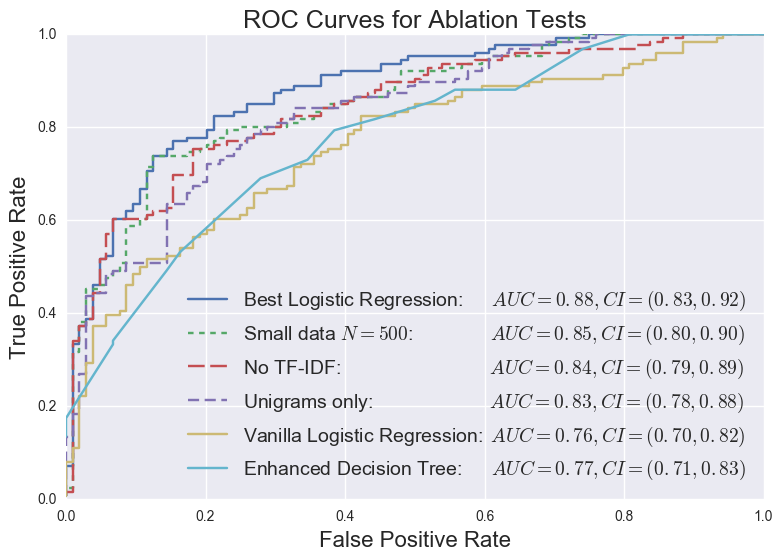

In [245]:
## Plot all the ROCs
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(best_roc[0], best_roc[1], '-', 
        label="Best Logistic Regression:$\;\;\,$   $AUC=%2.2f, CI=(%2.2f, %2.2f)$" % (best_auc, best_ci[0], best_ci[1]))
ax.plot(small_roc[0], small_roc[1], '-', dashes=[4,4],#[8, 4, 2, 4, 2, 4], 
        label="Small data $N=500$:       $\;\;\,$     $AUC=%2.2f, CI=(%2.2f, %2.2f)$" % (small_auc, small_ci[0], small_ci[1]))
ax.plot(bow_roc[0], bow_roc[1], '-', dashes=[12,4], 
        label="No TF-IDF:                  $\,$         $AUC=%2.2f, CI=(%2.2f, %2.2f)$" % (bow_auc, bow_ci[0], bow_ci[1]))
ax.plot(unigram_roc[0], unigram_roc[1], '-', dashes=[8,4], 
        label="Unigrams only:             $\,$        $AUC=%2.2f, CI=(%2.2f, %2.2f)$" % (unigram_auc, unigram_ci[0], unigram_ci[1]))
ax.plot(vanilla_roc[0], vanilla_roc[1], '-', #dashes=[12,4], 
        label="Vanilla Logistic Regression: $\,$$AUC=%2.2f, CI=(%2.2f, %2.2f)$"%(vanilla_auc, vanilla_ci[0], vanilla_ci[1]))
ax.plot(tree_roc[0], tree_roc[1], '-', #dashes=[8,8], 
        label="Enhanced Decision Tree: $\;\,$   $AUC=%2.2f, CI=(%2.2f, %2.2f)$"%(tree_auc, tree_ci[0], tree_ci[1]))


ax.legend(loc='best', fancybox=True, fontsize=14)
ax.set_title("ROC Curves for Ablation Tests", fontsize=18)
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
plt.savefig('auc_ablation_plot_revised.pdf')